In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


from pyfrac.modelling.kirchhoff import Kirchhoff

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Face definitions

F1 = Top face with well, Z=0
F2 = Bottom face, Z=40.5

F3 = X=0
F4 = X=40.5

F5 = Y=0
F6 = Y=40.5

## Line definitions
1-5: 

    x fixed per line, y changes, z changes 
    covers F1, F2, F3, F4
    x_loc = [7, 13.5, 23.2, 26.5, 33.5]

6-10: 

    x changes, y fixed per line, z changes 
    covers F1, F2, F5, F6
    y_loc = [33, 26.5, 17, 13.5, 7.5]

    
11-15: 

    x changes, y changes, z fixed per line 
    covers F3, F4, F5, F6
    z_loc = [33.5, 26.5, 20, 13.5, 7]

# my choice
points_per_line = 5

f0 = 0
fN = 40.5

changingdim = np.round(np.linspace(2.5,fN-2.5, points_per_line))
print(changingdim)

### Fixed X Lines

In [4]:
x_loc = [7, 13.5, 23.2, 26.5, 33.5]
xl_xyz = np.zeros([5, points_per_line*4, 3])
for i,x in enumerate(x_loc):
    xl_f1 = np.vstack([np.ones(len(changingdim))*x, changingdim, np.ones(len(changingdim))*f0, ]).T  ## z=0, y changes 
    xl_f2 = np.vstack([np.ones(len(changingdim))*x, changingdim, np.ones(len(changingdim))*fN, ]).T  ## z=40.5, y changes 
    xl_f3 = np.vstack([np.ones(len(changingdim))*x, np.ones(len(changingdim))*f0, changingdim, ]).T  ## y=0, z changes 
    xl_f4 = np.vstack([np.ones(len(changingdim))*x, np.ones(len(changingdim))*fN, changingdim, ]).T  ## y=40.5, z changes 
    xl_xyz[i] = np.vstack([xl_f1, xl_f2, xl_f3, xl_f4])
    

In [5]:
xl_xyz.shape

(5, 20, 3)

### Fixed Y Lines

In [6]:
y_loc = [33, 26.5, 17, 13.5, 7.5]
yl_xyz = np.zeros([5, points_per_line*4, 3])
for i,y in enumerate(y_loc):
    yl_f1 = np.vstack([changingdim, np.ones(len(changingdim))*y, np.ones(len(changingdim))*f0, ]).T  ## z=0, y changes 
    yl_f2 = np.vstack([changingdim, np.ones(len(changingdim))*y, np.ones(len(changingdim))*fN, ]).T  ## z=40.5, y changes 
    yl_f3 = np.vstack([np.ones(len(changingdim))*f0, np.ones(len(changingdim))*y, changingdim, ]).T  ## y=0, z changes 
    yl_f4 = np.vstack([np.ones(len(changingdim))*fN, np.ones(len(changingdim))*y, changingdim, ]).T  ## y=40.5, z changes 
    yl_xyz[i] = np.vstack([yl_f1, yl_f2, yl_f3, yl_f4])
    

In [8]:
yl_xyz[0]

array([[ 2. , 33. ,  0. ],
       [11. , 33. ,  0. ],
       [20. , 33. ,  0. ],
       [29. , 33. ,  0. ],
       [38. , 33. ,  0. ],
       [ 2. , 33. , 40.5],
       [11. , 33. , 40.5],
       [20. , 33. , 40.5],
       [29. , 33. , 40.5],
       [38. , 33. , 40.5],
       [ 0. , 33. ,  2. ],
       [ 0. , 33. , 11. ],
       [ 0. , 33. , 20. ],
       [ 0. , 33. , 29. ],
       [ 0. , 33. , 38. ],
       [40.5, 33. ,  2. ],
       [40.5, 33. , 11. ],
       [40.5, 33. , 20. ],
       [40.5, 33. , 29. ],
       [40.5, 33. , 38. ]])

### Fixed Z Lines

In [11]:
z_loc = [33.5, 26.5, 20, 13.5, 7]
zl_xyz = np.zeros([5, points_per_line*4, 3])
for i,z in enumerate(z_loc):
    zl_f1 = np.vstack([changingdim, np.ones(len(changingdim))*f0, np.ones(len(changingdim))*z, ]).T  
    zl_f2 = np.vstack([changingdim, np.ones(len(changingdim))*fN, np.ones(len(changingdim))*z, ]).T  
    zl_f3 = np.vstack([np.ones(len(changingdim))*f0, changingdim, np.ones(len(changingdim))*z, ]).T  
    zl_f4 = np.vstack([np.ones(len(changingdim))*fN, changingdim, np.ones(len(changingdim))*z, ]).T  
    zl_xyz[i] = np.vstack([zl_f1, zl_f2, zl_f3, zl_f4])
    

In [12]:
zl_xyz[0]

array([[ 2. ,  0. , 33.5],
       [11. ,  0. , 33.5],
       [20. ,  0. , 33.5],
       [29. ,  0. , 33.5],
       [38. ,  0. , 33.5],
       [ 2. , 40.5, 33.5],
       [11. , 40.5, 33.5],
       [20. , 40.5, 33.5],
       [29. , 40.5, 33.5],
       [38. , 40.5, 33.5],
       [ 0. ,  2. , 33.5],
       [ 0. , 11. , 33.5],
       [ 0. , 20. , 33.5],
       [ 0. , 29. , 33.5],
       [ 0. , 38. , 33.5],
       [40.5,  2. , 33.5],
       [40.5, 11. , 33.5],
       [40.5, 20. , 33.5],
       [40.5, 29. , 33.5],
       [40.5, 38. , 33.5]])

# SET UP IMAGING 

In [41]:
nx, ny, nz = 42, 42, 42
dx, dy, dz = 0.01, 0.01, 0.01
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

# Velocity Model
vp = 5260  # m/s
vel = np.ones([nx,ny,nz])*vp
print(vel.shape)

(42, 42, 42)


In [40]:
max(x)

0.41000000000000003

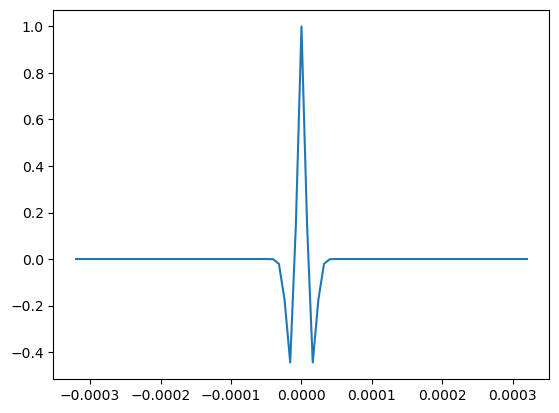

In [54]:
fwav = 25*1000
fs_kHz = 125
fs = fs_kHz * 1000

dt = 1/fs
ntfrwd = int(0.1 * fs)
t = (np.arange(ntfrwd)*dt)[:ntfrwd]
wav, wavt, wavc = ricker(t[:41], f0=fwav)

plt.plot(wavt, wav,)

In [37]:
# Microseismic sources
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

In [42]:
# Receiver Geometry 
rec_lines = np.vstack([xl_xyz, yl_xyz, zl_xyz])/100
# rec_lines.shape
recs_xyz = rec_lines.reshape([rec_lines.shape[0]*rec_lines.shape[1],rec_lines.shape[2]]).T
recs_xyz.shape

(3, 300)

In [43]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs_xyz[:, :1], 
               recs=recs_xyz, 
               vel=vel, 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-1079.690881864346 - u^H(Op^Hv)=-1079.6908818643544


# INVERSE CRIME

(300, 125000)


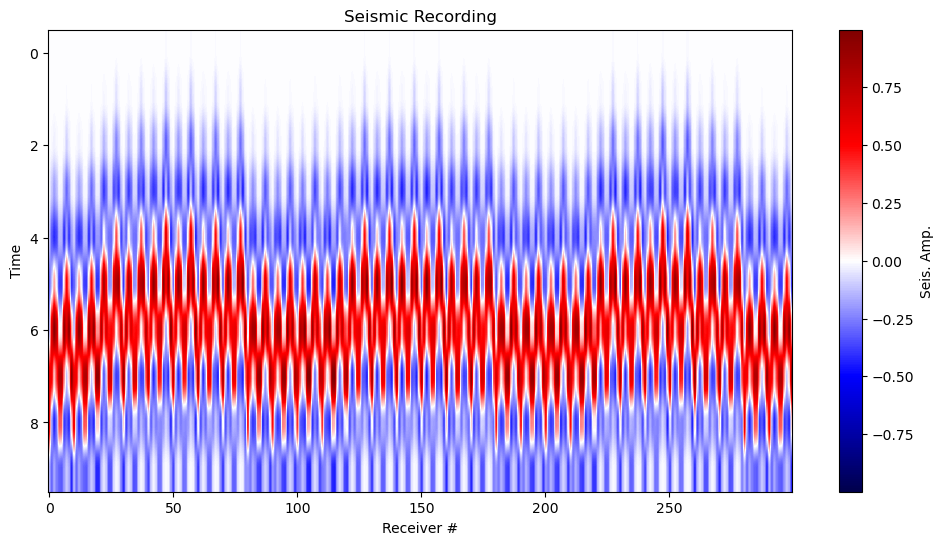

In [52]:
# PERFORM FORWARD (MODEL)
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(recs_xyz.shape[1],ntfrwd)

traceimage(frwddata[:,:10], climQ=99.99)
print(frwddata.shape)

In [50]:
from pyfrac.locationsolvers.imaging import *
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

In [56]:
inv, inv_hc = lsqr_migration(Op, frwddata, [nx,ny,nz], nforhc=10, verbose=False)
fista, fista_hc = fista_migration(Op, frwddata, [nx,ny,nz], nforhc=10, verbose=False, fista_eps=1e1)

print('LSQR Inversion Hypo-Centers:', inv_hc)
print('FISTA Inversion Hypo-Centers:', fista_hc)

fig,axs = locimage3d(inv, x0=sx, y0=sy)
fig,axs = locimage3d(fista, x0=sx, y0=sy, p=100)


KeyboardInterrupt



# PSUEDO-DAS

In [55]:
n_faces = 6
faces_per_line = 4

# LINE A
RLA_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,2,3],
                      axis=0
                     )
SLA_Op = Sum((faces_per_line, nr_x, nr_x, nt), axis=2)

# LINE B
RLB_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[2,3,4,5],
                      axis=0
                     )
SLB_Op = Sum((faces_per_line, nr_x, nr_x, nt), axis=2)

# LINE C
RLC_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,4,5],
                      axis=0
                     )
SLC_Op = Sum((faces_per_line, nr_x, nr_x, nt), axis=2)

# COMBINING OPERATORS
Vop = VStack([SLA_Op.H @ SLA_Op @ RLA_Op, 
              SLB_Op.H @ SLB_Op @ RLB_Op,
              SLC_Op.H @ SLC_Op @ RLC_Op
             ])

LinesOp = Vop * Op

# check operator with dottest
_ = dottest(LinesOp, verb=True)

(300, 125000)

In [59]:
frwddata_seplines = frwddata.reshape([6,frwddata.shape[0]//6,frwddata.shape[1]])

<Axes: title={'center': 'Seismic Recording'}, xlabel='Receiver #', ylabel='Time'>

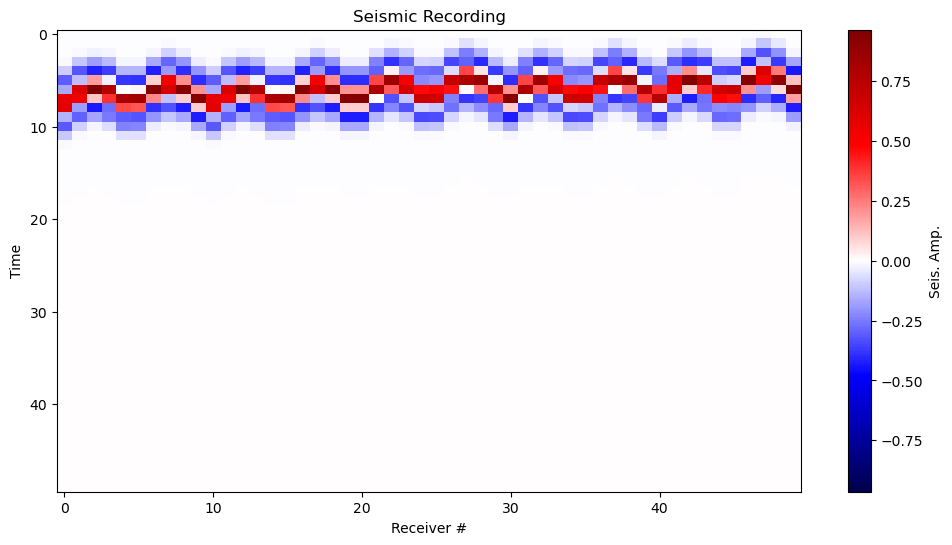

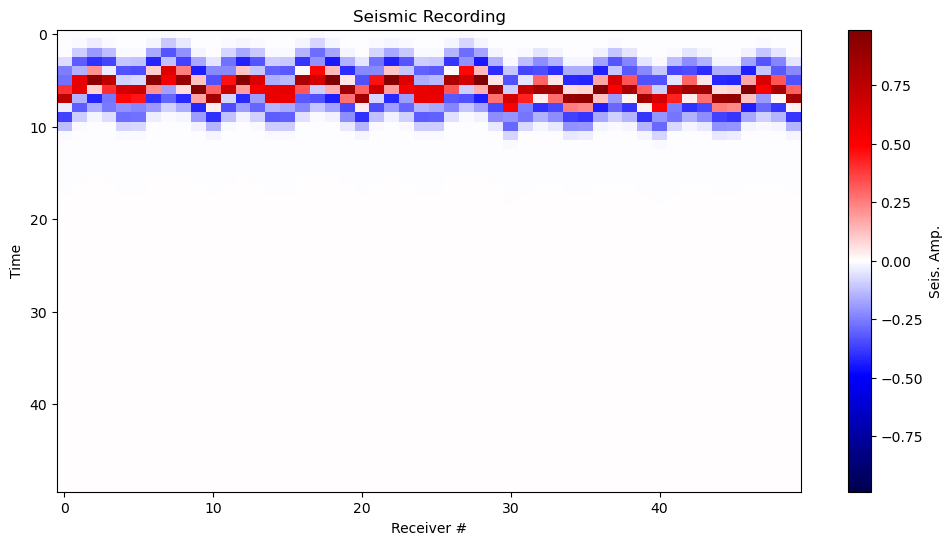

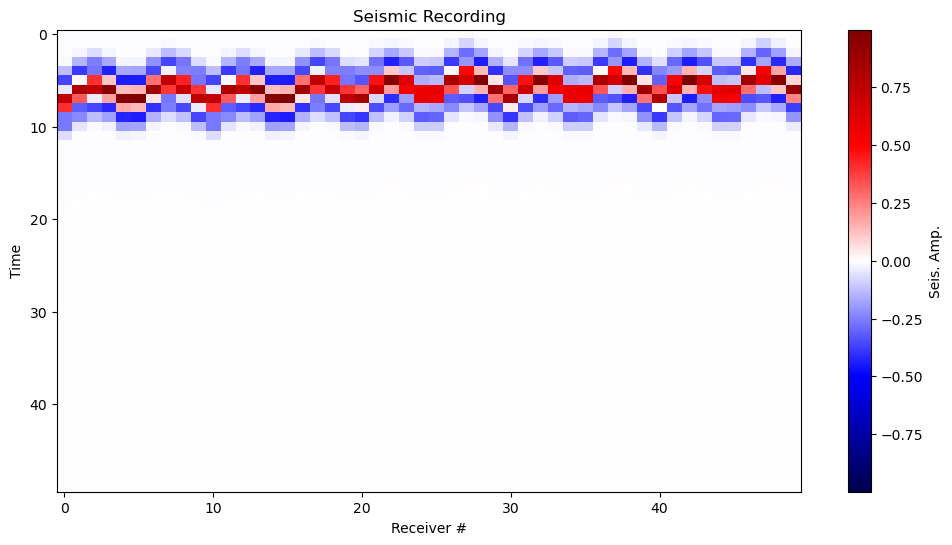

In [63]:
traceimage(frwddata_seplines[0,:,:50], climQ=99.99)
traceimage(frwddata_seplines[1,:,:50], climQ=99.99)
traceimage(frwddata_seplines[2,:,:50], climQ=99.99)